# 第2部 モンテカルロ法と推定

- 2.1 確率論的プログラミングとは
- 2.2 点推定，区間推定
    - EAP
    - MAP
    - MED
    - 区間推定
- 2.2 モンテカルロサンプリングとパラメータ推定
- 2.4 マルコフ鎖モンテカルロ(MCMC)のさわり
- 2.5 計算機実装(コイン投げ coin: pymc3, pystan)
    - pymc3
    - pystan

## 2.1  確率論的プログラミングとは

![alt text](fig/infer.png "infer")

- 確率分布としてパラメータを決める
- パラメータを含んだ事前分布と尤度を用いて数式をたてる．これをモデリングという．
- ベイズの定理に観測データを適用して，ベイズ更新し事後分布を求める
- 事後分布から直接，点推定，区間推定はできない．
- マルコフチェーン・モンテカルロでパラメータを推定する

## 2.2 点推定，区間推定

### 2.2.1 点推定

#### 事後期待値(expected a posteriori, EAP): 

事後分布の期待値を推定値とする

$$
\hat{\theta_{eap}} = E[\theta|D]\\
 = \int d\theta \cdot \theta \cdot p(\theta|D) \\
 = \int d\theta \cdot \theta \cdot \frac{p(D|\theta) p(\theta)}{p(D)}
$$

#### 事後確率最大値(maximum a posteriori, MAP): 

事後分布の最大値を期待値の推定値とする

$$
\hat{\theta_{map}} = max_\theta p(\theta|D)
$$

#### 事後中央値 (posterior median, MED): 

事後分布の中央値を期待値の推定値とする -> 分布関数 $F$が0.5になるメディアン値を推定値とする．

$$
F(\hat{\theta_{med}} | D) = \int^{\theta_{med}} d\theta \cdot f(\theta | D ) = \frac{1}{2}
$$

### 2.2.2 区間推定

幅をもたせてパラメータの推定をおこなう方法で，確率分布の極端な両端の$\alpha$%をのぞいた$(1 - \alpha)$%の部分を推定幅として用いる．伝統的な統計学では，$\alpha = 5$%を使うことが多い．

## 2.3 モンテカルロサンプリングとパラメータ推定

なぜモンテカルロサンプリングが必要なのか．それは，事後分布のランダムサンプリングが可能ならば，簡単にモデルのパラメータを推定できるから，である．

次の事後期待値を考える．

$$
\int d\theta \cdot f(\theta) p(\theta)
$$

![alt text](fig/monte1.png "monte1")

結局，以下のように，事後分布のランダムサンプリングが可能ならば，簡単にモデルのパラメータを推定できることがわかった．

$$
\int d\theta \cdot f(\theta) p(\theta) = \frac{1}{N} \sum_{\theta_j \sim p(\theta_j)} f(\theta_j)
$$




## 2.4 マルコフチェーンモンテカルロのさわり

MCMCとは，マルコフチェーンを利用して，欲しい確率分布（目標分布）の乱数を生成するアルゴリズムのことをさす．

マルコフチェーンとは，以下のような，一期前の変数にだけ依存するような条件付き確率で表現できる確率過程をいいます．

$$
p(X^{(t)}|X^{(t-1)}, X^{(t-2)}, \dots, X^{(1)}) = p(X^{(t)}|X^{(t-1)})
$$

マルコフチェーンを規定する条件付き確率事態を遷移確率の行列を遷移核といいいます．

マルコフチェーンを利用する理由は，目標分布である定常状態に収束することが確率論的に保証されているからです．収束するまえの状態にあるチェーンは「バーン・イン, burn-in」といって，通常バーン・インにあるチェーンは取り除いて利用する．

MCMC法のアルゴリズムには以下のものがある．

	- メトロポリス・ヘイスティング法
        - ランダムメトロポリス・ヘイスティング法
    - ギブスサンプリング法
        - スライスサンプリング
	- ハミルトニアンモンテカルロ法
        - NUTS(No-U-Turn Sampler)


### 2.4.1 メトロポリス・ヘイスティング法

- マルコフチェーンを利用して，事後分布に従う乱数を生成する．
- 一番簡単なMCMC方のアルゴリズム

$$\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\corr}{{\rm corr}}
\newcommand{\xss}{x^{(i+1)}}
\newcommand{\xs}{x^{\star}}
\newcommand{\xt}{x^{(i)}}
\newcommand{\xa}{x_a}
\newcommand{\xb}{x_b}$$

------

- 初期値として$x^{(1)}$を適当に定める
- 現在値を$\xt$として，提案分布$q(\xs|\xt)$を使って候補として$\xs$をサンプリングする．
- 以下の受け入れ確率で，$\xs$だけ動くか，それとも$\xt$にそのままでいるかを決める．

$$
A(\xt,\xs) = \min\left[1, \frac{p(\xs) \, q(\xt|\xs)}{p(\xt) q(\xs|\xt) } \right] 
$$

------
* Initialize $x^{(1)}$ 
* For i=2 to N 
   * Sample $u\sim U(0,1)$ 
   *  Sample $\xs \sim q(\xs|x^{(i)})$ 
   *  if $u<A(x^{(i)},\xs) = \min\left[1, \frac{p(\xs) \, q(x^{(i)}|\xs)}{p(x^{(i)}) q(\xs| \xt ) } \right]  $
   
   $x^{(i+1)}=\xs$
   * else  
		$x^{(i+1)}=x^{(i)}$
------

注意：もし遷移確率が以下のように対称なら，

$$q(\xs|x^{(i)}) = q(x^{(i)}|\xs)$$

受け入れ確率を以下のようにすること．

$$ A(x,\xs) = \min\left[1, \frac{p(\xs)}{p(x) } \right] $$

### MHアルゴリズムの実装例

目標分布： $$p(x) =6x(1-x)$$

提案分布： $$\xs \sim N(x, 0.6) $$

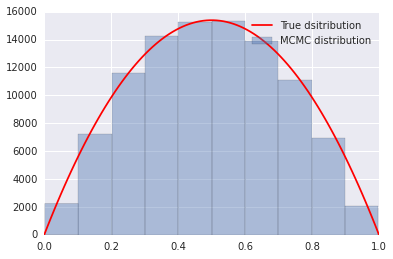

In [27]:
%matplotlib inline 
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

## FUNCTIONS 
# target distribution p(x) 
p = lambda x: 6*x*(1-x)

# number of samples
n = 100000

sig =0.10

#intitialize the sampling. Start somewhere from 0..1
x0 = np.random.uniform()

x_prev = x0

x=[]
k=1
i=0
while i<n:
    
    x_star = np.random.normal(x_prev, sig)
    while  (x_star <0) | (x_star > 1):  # MAKE SURE WE STAY WITHIN BOUNDS
        x_star = np.random.normal(x_prev, sig)

    P_star = 6*x_star*(1-x_star) #p(x_star);
    P_prev = 6*x_prev*(1-x_prev) #p(x_prev);
    U =  np.random.uniform()
    
    A =  P_star/P_prev
    if U < A:
        x.append(x_star)
        i = i + 1
        x_prev = x_star
    else :
        x.append(x_prev)
        x_prev = x[i]  
        i = i + 1
 
        k=k+1

e,q,h=plt.hist(x,10, alpha=0.4, label=u'MCMC distribution') 

xx= np.linspace(0,1,100)
plt.plot(xx, 0.67*np.max(e)*p(xx), 'r', label=u'True dsitribution') 
plt.legend()

In [1]:
from IPython.display import YouTubeVideo

# Bayesian Inference and MCMC (Bob Carpenter) 2:03:10 (t=7390)
YouTubeVideo('qQFF4tPgeWI')

### 2.4.2 ハミルトニアンモンテカルロ法

- ハミルトン力学(解析力学）のアナロジーで，サンプリングの遷移を力学的に決めることで，事後分布に従う乱数を生成する．
    - パラメータ空間 -> 位相空間
    - ある特徴的なパラメータ -> 運動量
    - ポテンシャル -> マイナスの事後分布
    - 位相空間と運動量の連立微分方程式であるハミルトン方程式をたて，リープフロッグ法で解く
    
$$
\frac{d p(\tau)}{d\tau} = - h(\theta(\tau)) \\
\frac{d \theta(\tau)}{d\tau} = - p(\tau)
$$
- HMCの計算機実装：PyMC3, Stanの二つが現在の所まともなHMCの実装(LaplacesDeamonはおそらく死亡…)
- 日本語の文献：豊田秀樹編著, 基礎からのベイズ統計学 - ハミルトニアンモンテカルロ法による実践的入門

In [17]:
# Hamiltonian Monte Carlo and Stan (Michael Betancourt) 58:25 (t=3507)
YouTubeVideo('pHsuIaPbNbY')

###2.4.3 MH, Gibbs, HMCのサンプリングの比較デモ

In [30]:
# HT: Thomas Wiecki
from IPython.display import IFrame
IFrame('http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/', width='100%', height=1000)

## 2.5 計算機実装

### 2.5.1 pymc3

- pythonのMCMC実装の老舗プロジェクト
- pymc3はpymc2とは別に，完全に新しく始めたプロジェクト．
- シンタックスが簡単
- いけてるサンプリングアルゴリズム: NUTS
    - NUTS, Metropolis, Slice, HamiltonianMC, BinaryMetropolis
- Theano
    - Theanoの自動微分機能を用いて，解析的にモデルのグラジェントを計算
    - CUDAを利用したGPU計算でパフォーマンスが期待できる
    - JITコンパイル: python/Numpy - theano -> C -> GPU/CPU
- 非常に期待したいが…．
    - コアの開発者が三人しかいない: John Salvatier, Thomas Wiecki, Chris Fonnesbeck.
    - ドキュメントがプアである…．ただし，Thomas Wieckiのブログが孤軍奮闘
    - Theanoからのもらいバグが多い…
    - 最近開発が止まりガチ…

In [21]:
# John Salvatier: "Bayesian inference with PyMC 3" in PyData Seattle 2015
YouTubeVideo('VVbJ4jEoOfU')

In [20]:
# Thomas Wiecki: "Probabilistic Programming in Python" in EuroPython 2014 
YouTubeVideo('KqTUNJ1smYM')

In [24]:
# Thomas Wiecki: "Bayesian Data Analysis with PyMC3" in PyData NYC 2013 
IFrame('http://twiecki.github.io/blog/2013/12/12/bayesian-data-analysis-pymc3/', width='100%', height=400)

### 2.5.2 stan/pystan

- ハミルトン･モンテカルロ法のスター研究者達が自らC++でコーディングしている実装
    - Andrew Gelmanをリーダに，NUTS法や変分ベイズのMatthew Hoffmanやリーマン多様体HMCのMichael Betancourtなど．
- HMC法を実装する実装（stan, pymc3)のなかで，一番最新の機能実装が進んでいる．
    - 変分ベイズも実装済み．リーマン多様体HMCも実装中．
- ドキュメントが充実している．勝手にStan入門が充実している．
    - "Modeling Language User’s Guide and Reference Manual" [stan-reference-2.8.0.pdf](https://github.com/stan-dev/stan/releases/download/v2.8.0/stan-reference-2.8.0.pdf)
- Pythonより圧倒的にRから使われることが多い．

In [3]:
# Ehsan Karim: "Stan for the beginners [Bayesian inference] in 6 mins "
YouTubeVideo('tLprFqSWS1w')

In [18]:
# Bob Carpenter: "Bayesian Inference and MCMC" in MLSS Sydney 2015
YouTubeVideo('6NXRCtWQNMg')

In [19]:
# Michael Betancourt: "Hamiltonian Monte Carlo and Stan" in MLSS Iceland 2014
YouTubeVideo('xWQpEAyI5s8')